In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from torch.utils.tensorboard import SummaryWriter


def loadtraindata():
    path = r"./train"
    trainset = torchvision.datasets.ImageFolder(path,
                                                transform=transforms.Compose([
                                                    transforms.Resize((100, 100)),  # 将图片缩放到指定大小（h,w）
                                                    transforms.CenterCrop(64),
                                                    transforms.ToTensor()])
                                                )

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                              shuffle=True, num_workers=2)
    return trainloader


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)  # 卷积层0
        self.pool = nn.MaxPool2d(2, 2)  # 池化层
        self.conv2 = nn.Conv2d(6, 16, 5)  # 卷积层
        self.fc1 = nn.Linear(2704, 120)  # 全连接层
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 2704)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


classes = ('不是奥特曼', '奥特曼')


def loadtestdata():
    path = r"./test"
    testset = torchvision.datasets.ImageFolder(path,
                                               transform=transforms.Compose([
                                                   transforms.Resize((64, 64)),
                                                   transforms.ToTensor()])
                                               )
    testloader = torch.utils.data.DataLoader(testset, batch_size=25,
                                             shuffle=True, num_workers=2)
    return testloader


def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        

def images_to_probs(net, images):
    output = net(images)
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    preds, probs = images_to_probs(net, images)
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig


def trainandsave():  # 训练
    writer = SummaryWriter('runs/aoteman_1')
    trainloader = loadtraindata()
    net = Net()
    optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    criterion = nn.CrossEntropyLoss()
    for epoch in range(500):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            inputs, labels = Variable(inputs), Variable(labels)

            img_grid = torchvision.utils.make_grid(inputs)
            writer.add_image('aoteman', img_grid)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 40 == 39:
                writer.add_scalar('training loss',running_loss / 40,epoch * len(trainloader) + i)
                writer.add_figure('predictions vs. actuals',plot_classes_preds(net, inputs, labels),global_step=epoch * len(trainloader) + i)
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 40))
                running_loss = 0.0
            torch.save(net, './out/net'+str(epoch)+'.pkl')
            torch.save(net.state_dict(), './out/net_params'+str(epoch)+'.pkl')

    print('Finished Training')



def reload_net():
    trainednet = torch.load('net.pkl')
    return trainednet


def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


def test():
    testloader = loadtestdata()
    net = reload_net()
    dataiter = iter(testloader)
    images, labels = dataiter.next()
    imshow(torchvision.utils.make_grid(images, nrow=5))
    print('GroundTruth: '
          , " ".join('%5s' % classes[labels[j]] for j in range(25)))  # 打印前25个测试图
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)

    print('Predicted: ', " ".join('%5s' % classes[predicted[j]] for j in range(25)))


def test_one(img_path):
    model = reload_net()
    transform_valid = transforms.Compose([
        transforms.Resize((64, 64), interpolation=2),
        transforms.ToTensor()
    ]
    )
    img = Image.open(img_path)
    img_ = transform_valid(img).unsqueeze(0)
    outputs = model(img_)
    _, indices = torch.max(outputs, 1)
    result = classes[indices]
    print('predicted:', result)
    print(outputs)


def main():
    trainandsave()
    test()
    test_one(r'./test1.jpg')


D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 19981 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26159 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 22885 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 29305 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 26364 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 19981 missing from current font.
  font.set_text(s, 0, flags=flags)
D:\Anaconda3\lib\site-pa

[1,    40] loss: 0.695
[2,    40] loss: 0.696
[3,    40] loss: 0.682
[4,    40] loss: 0.694
[5,    40] loss: 0.691
[6,    40] loss: 0.684
[7,    40] loss: 0.692
[8,    40] loss: 0.689
[9,    40] loss: 0.689
[10,    40] loss: 0.690
[11,    40] loss: 0.682
[12,    40] loss: 0.684
[13,    40] loss: 0.678
[14,    40] loss: 0.678
[15,    40] loss: 0.664
[16,    40] loss: 0.666
[17,    40] loss: 0.663
[18,    40] loss: 0.597
[19,    40] loss: 0.638
[20,    40] loss: 0.606
[21,    40] loss: 0.601
[22,    40] loss: 0.569
[23,    40] loss: 0.545
[24,    40] loss: 0.561
[25,    40] loss: 0.534
[26,    40] loss: 0.559
[27,    40] loss: 0.556
[28,    40] loss: 0.539
[29,    40] loss: 0.520
[30,    40] loss: 0.474
[31,    40] loss: 0.427
[32,    40] loss: 0.387
[33,    40] loss: 0.399
[34,    40] loss: 0.368
[35,    40] loss: 0.387
[36,    40] loss: 0.307
[37,    40] loss: 0.338
[38,    40] loss: 0.590
[39,    40] loss: 0.262
[40,    40] loss: 0.237
[41,    40] loss: 0.210
[42,    40] loss: 0.177
[

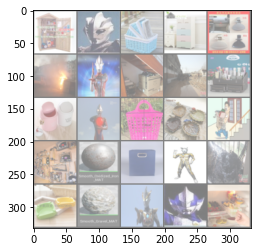

GroundTruth:  不是奥特曼   奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼 不是奥特曼   奥特曼   奥特曼 不是奥特曼
Predicted:  不是奥特曼   奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼   奥特曼 不是奥特曼   奥特曼   奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼   奥特曼 不是奥特曼 不是奥特曼
predicted: 奥特曼
tensor([[-0.1119,  0.0654]], grad_fn=<AddmmBackward>)


In [5]:
main()

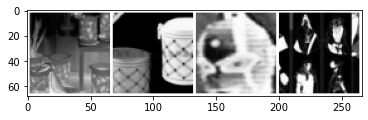

In [2]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
writer = SummaryWriter('runs/fashion_mnist_experiment_1')
dataiter = iter(loadtraindata())
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid, one_channel=True)
writer.add_image('four_fashion_mnist_images', img_grid)

In [4]:
writer.add_graph(Net(), images)
writer.close()

In [3]:
torch.cuda.is_available()

True